# MCM RB Example Notebook 

Load a device and produce sets of all qubits + ancillas for running mcm-rb

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate
import numpy as np
from qiskit_experiments.framework import BatchExperiment

import sys 
sys.path.append('../')
import qiskit_device_benchmarking.utilities.graph_utils as gu
from qiskit_device_benchmarking.bench_code.mcm_rb import McmRB

In [2]:
#put your info here
my_hub = ''
my_group = ''
my_project = ''

service = QiskitRuntimeService(instance='%s/%s/%s'%(my_hub,my_group,my_project))
my_backend = 'ibm_pinguino1'

backend_real = service.backend(my_backend)
nq_backend = backend_real.num_qubits
coupling_map = backend_real.coupling_map


In [3]:
print('Measurement Length: %.2e'%backend_real.properties().readout_length(0))
print('Single Q Gate Length: %.2e'%backend_real.properties().gate_length('x',0))

Measurement Length: 1.40e-06
Single Q Gate Length: 6.00e-08


In [4]:
#Partition the device into subsets that can be probed in parallel
#this separation sets how far qubits can be apart, should be minimum 4
q_separation = 5

#remove faulty qubits
fq = backend_real.properties().faulty_qubits()
print(f"faulty qubits: {fq}")
gg = gu.build_sys_graph(nq_backend,coupling_map, faulty_qubits=fq)
qlist = list(range(nq_backend))
qsets = gu.get_separated_sets(gg,[[i] for i in qlist],min_sep=q_separation)

faulty qubits: []


In [5]:
#number of separate experiments to probe all qubits
print(len(qsets))
print(qsets)

10
[[[0], [5], [10], [24], [29], [33], [49], [54], [56], [74], [75], [80], [85], [100], [105], [109], [124]], [[1], [6], [11], [20], [25], [32], [45], [52], [53], [55], [76], [81], [86], [96], [101], [108], [120]], [[2], [7], [12], [19], [34], [35], [36], [37], [59], [64], [69], [79], [84], [90], [104], [110], [112], [113]], [[3], [8], [13], [18], [38], [43], [48], [58], [63], [70], [83], [91], [93], [94], [115], [121], [126]], [[4], [9], [14], [28], [39], [44], [50], [57], [62], [73], [89], [95], [102], [107], [116], [123]], [[15], [16], [17], [40], [46], [51], [66], [71], [72], [88], [97], [103], [117], [125]], [[21], [26], [31], [41], [65], [77], [82], [87], [99], [111], [114]], [[22], [27], [42], [67], [78], [92], [106], [118]], [[23], [30], [60], [68], [98], [119]], [[47], [61], [122]]]


## Build the experiments

In [6]:
# define sequences lengths
lengths = [1, 5, 10, 15, 20, 50, 100]

# number of randomizations
n_seeds = 4

# use dynamical decoupling
b_dd = False

# number of single qubit cliffords between measurements
# sometimes playing with these can help with the buffer errors
# 5-10
n_cliffs_per_meas = 5

expr_list = []
qsets_mcm = []

for i in range(len(qsets)):
    qsets_mcm.append([])
    if b_dd:
        expr_list.append(
            McmRB(
                clif_qubit_sets=qsets[i],
                meas_qubit_sets=[list(gg.neighbors(ii[0])) for ii in qsets[i]],
                lengths=lengths,
                backend=backend_real,
                num_samples=n_seeds,
                cliff_per_meas=n_cliffs_per_meas,
                dd_sequence=[XGate(), XGate()],
                staggered_dd=True,
                dd_spacing_a=[0.25, 0.5, 0.25],  # default spacing for 1st qubit set (sum = 1),
                dd_spacing_b=[0.5, 0.5, 0],  # default spacing for 2nd qubit set (sum = 1)
            )
        )
    else:
        expr_list.append(
            McmRB(
                clif_qubit_sets=qsets[i],
                meas_qubit_sets=[list(gg.neighbors(ii[0])) for ii in qsets[i]],
                lengths=lengths,
                backend=backend_real,
                num_samples=n_seeds,
                cliff_per_meas=n_cliffs_per_meas,
            )
        )

    for ii in range(len(qsets[i])):
        qsets_mcm[-1].append(qsets[i][ii] + list(gg.neighbors(qsets[i][ii][0])))

print(
    "First set has %d qubits and %d ancillas"
    % (
        len(qsets[0]),
        np.sum([len(qsets_mcm[0][i]) for i in range(len(qsets_mcm[0]))]) - len(qsets[0]),
    )
)
print(
    "Total measurements per job is %d and should be <5000"
    % (n_seeds * 3 * (np.sum(np.array(lengths) + 1)))
)
print("If more measurements are needed, split up the job")

First set has 17 qubits and 38 ancillas
Total measurements per job is 2496 and should be <5000
If more measurements are needed, split up the job


In [7]:
#run this if you want an example circuit
b_show = False
if b_show:
    display(expr_list[0]._transpiled_circuits()[0].draw('mpl', idle_wires=False))

In [8]:
#some rep relay tricks

#does the backend support rep delay changes?
print('Backend Supports Dynamic Rep Delay')
print(backend_real.configuration().dynamic_reprate_enabled)

#what is the range?
print('Backend rep delay range')
print(backend_real.configuration().rep_delay_range)

#what is the default rep delay
print('Backend rep delay default')
print(backend_real.configuration().default_rep_delay)

Backend Supports Dynamic Rep Delay
True
Backend rep delay range
[0.0, 0.0005]
Backend rep delay default
0.00025


## Run the experiements

In [ ]:
#run in single mode until sure it won't buffer overflow or use session
run_batch = True
#run only part of the experiments
number_of_exps = 2 # or None


if run_batch:
    if number_of_exps:
        exps = expr_list[:number_of_exps]
    else:
        exps = expr_list
    print('This will launch %d Jobs'%(len(exps)))
    new_exp = BatchExperiment(exps,flatten_results=True, backend=backend_real)
    new_exp.set_experiment_options(separate_jobs=True)
    
    from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
    with Session(backend=backend_real) as session:
        sampler = Sampler()
        sampler.options.default_shots = 300
        sampler.options.execution.rep_delay = 0.0005
        expdata = new_exp.run(sampler=sampler)
else:
    #run a single job
    exp_set_id = 0
    new_exp = expr_list[exp_set_id]
    #new_exp.set_experiment_options(max_circuits=45)
    new_exp.set_run_options(shots=300, rep_delay=0.0005)
    expdata = new_exp.run()
    expdata.experiment_id


In [10]:
#these are the job ids
# print(expdata.job_ids)

In [12]:
print(expdata.job_status())
print(expdata.analysis_status())

JobStatus.DONE
AnalysisStatus.DONE


In [13]:
#number of figures
len(expdata.figure_names)

34

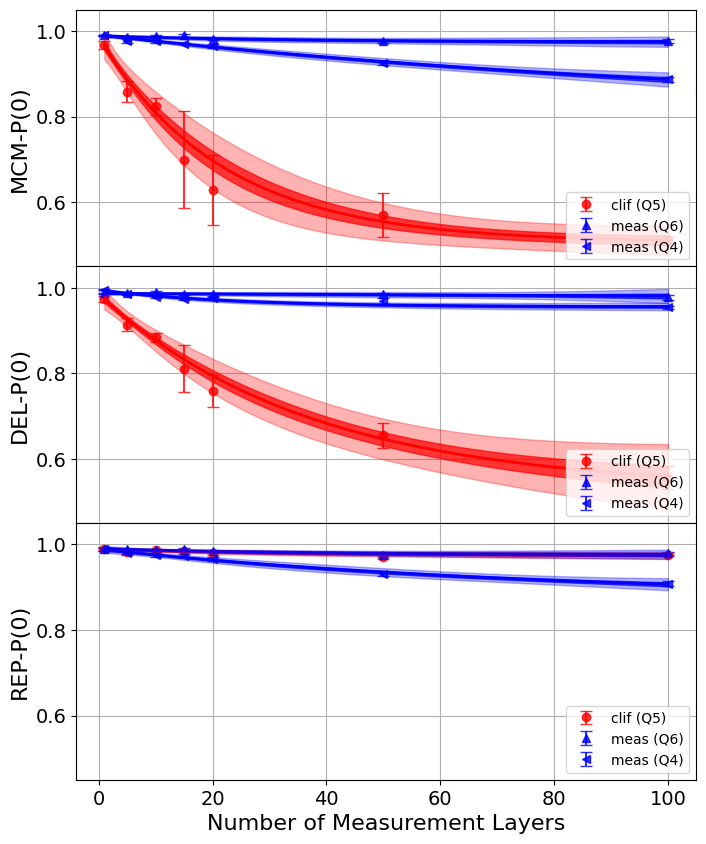

In [14]:
# plot some figure
expdata.figure(1)

In [15]:
#find the experiment and set corresponding to a specific qubit
#the first qubit in the set is the "qubit" and the reset are the ancilla
qubit_num = 24
for i in range(len(qsets_mcm)):
    for j in range(len(qsets_mcm[i])):
        if qubit_num in qsets_mcm[i][j]:
            print('Exp %d, set %d -- %s'%(i,j,qsets_mcm[i][j]))

Exp 0, set 3 -- [24, 25, 23, 34]
Exp 1, set 4 -- [25, 26, 24]
Exp 2, set 4 -- [34, 43, 24]
Exp 8, set 0 -- [23, 24, 22]


Fig ID 3


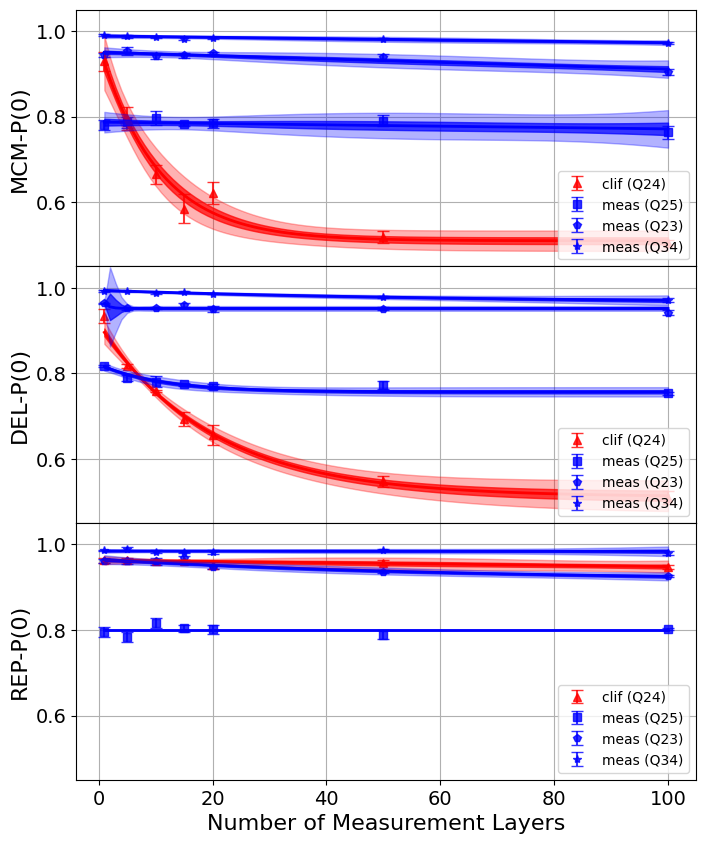

In [16]:
#Because we flattened the batch results the figure ID needs to be converted
#from the exp set and index inside the experiment (see cell above)
fig_id = np.sum([len(i) for i in qsets_mcm[0:0]]) + 3
print('Fig ID %d'%fig_id)
expdata.figure(int(fig_id))

In [17]:
#get the data from from the analysis
df = expdata.analysis_results(dataframe=True)
df.head(5)

,name,experiment,components,value,quality,backend,run_time,chisq,group
0dd9286e,alpha_mcm_clif_q0,McmRB,"[Q0, Q5, Q10, Q24, Q29, Q33, Q49, Q54, Q56, Q7...",0.969+/-0.005,good,ibm_pinguino1,None,2.090931,mcm_0_0
64e58e03,alpha_del_clif_q0,McmRB,"[Q0, Q5, Q10, Q24, Q29, Q33, Q49, Q54, Q56, Q7...",0.9850+/-0.0030,good,ibm_pinguino1,None,2.312094,del_0_0
8a693bc8,alpha_rep_clif_q0,McmRB,"[Q0, Q5, Q10, Q24, Q29, Q33, Q49, Q54, Q56, Q7...",0.9999999999999997+/-nan,good,ibm_pinguino1,None,0.295592,rep_0_0
119a9606,alpha_mcm_meas_q14,McmRB,"[Q0, Q5, Q10, Q24, Q29, Q33, Q49, Q54, Q56, Q7...",0.974+/-0.007,bad,ibm_pinguino1,None,3.696413,mcm_14_0
8d0d90ac,alpha_del_meas_q14,McmRB,"[Q0, Q5, Q10, Q24, Q29, Q33, Q49, Q54, Q56, Q7...",0.985+/-0.035,good,ibm_pinguino1,None,1.348909,del_14_0


In [18]:
#Look at the qnd analysis
#This looks at the DROP relative drop in the REP experiment value of the measurement
#qubits after 100 measurements using the fit values
#1.0 is a perfect QND measurement

df[(df.name=='qnd_err_100rep_drop') & (df.value<=0.85)]

,name,experiment,components,value,quality,backend,run_time,chisq,group
3c76f096,qnd_err_100rep_drop,McmRB,[Q96],0.569+/-0.008,bad,ibm_pinguino1,None,None,None
cba49ac6,qnd_err_100rep_drop,McmRB,[Q101],(0+/-4)e+04,bad,ibm_pinguino1,None,None,None
bc77acbb,qnd_err_100rep_drop,McmRB,[Q44],0.653+/-0.013,bad,ibm_pinguino1,None,None,None
6935ed5e,qnd_err_100rep_drop,McmRB,[Q46],0.363+/-0.012,bad,ibm_pinguino1,None,None,None
2b63536e,qnd_err_100rep_drop,McmRB,[Q54],0.464+/-0.009,bad,ibm_pinguino1,None,None,None


In [19]:
#Look at the mid-circuit measurement error on the qubit
#This is 0.5*(1-alpha_mcm/alpha_delay) where in the mcm experiment there are
#measurements on the ancilla and in delay there is just a delay on the ancilla

#large positive error is BAD
df[(df.name == "mcm_rb_err") & (df.value>=0.015)]

,name,experiment,components,value,quality,backend,run_time,chisq,group
3c22871a,mcm_rb_err,McmRB,[Q24],0.023+/-0.006,bad,ibm_pinguino1,None,None,None
b1d16788,mcm_rb_err,McmRB,[Q54],0.019+/-0.010,bad,ibm_pinguino1,None,None,None
ec0084ee,mcm_rb_err,McmRB,[Q80],0.021+/-0.004,bad,ibm_pinguino1,None,None,None
363685f0,mcm_rb_err,McmRB,[Q25],0.025+/-0.020,bad,ibm_pinguino1,None,None,None
b086651d,mcm_rb_err,McmRB,[Q32],0.25255597503567606+/-nan,bad,ibm_pinguino1,None,None,None
6754b38e,mcm_rb_err,McmRB,[Q53],0.074+/-0.017,bad,ibm_pinguino1,None,None,None
ac22fc60,mcm_rb_err,McmRB,[Q55],0.033+/-0.004,bad,ibm_pinguino1,None,None,None
0abf3217,mcm_rb_err,McmRB,[Q76],0.0190+/-0.0035,bad,ibm_pinguino1,None,None,None


In [20]:
#this is all the curve fit data
# expdata.artifacts()[1].data

In [21]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()